# Classificador de Artistas

O objetivo desse desafio é classificar com base no trecho de uma musica, qual artista é o cantor.



In [46]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

## Extração de dados

In [6]:
data = pd.read_excel("Data/dataset.xls", sheet_name='NLP')

In [7]:
data

,letra,artista
0,Jay-z Uh-uh-uh You ready b? Let's go get 'em. ...,Beyoncé
1,Your challengers are a young group from Housto...,Beyoncé
2,"Dum-da-de-da Do, do, do, do, do, do (Coming do...",Beyoncé
3,If I ain't got nothing I got you If I ain't go...,Beyoncé
4,Six inch heels She walked in the club like nob...,Beyoncé
...,...,...
513,Yeah yeah Yeah yeah I ain't trying to think a...,Rihanna
514,You the one that I dream about all day You the...,Rihanna
515,"No, no, no You don't love me and I know now No...",Rihanna
516,"You should be mine Oh baby, oh baby, oh baby, ...",Rihanna


## Analise Exploratoria

### Distribuiçao das classes

Um ponto inicial interessante é analisar a distribuição das classes e verificar se há dados desbalanceados ou não, para que assim possa inferido a necessidade de tratamentos especiais como data agumentation ou não.

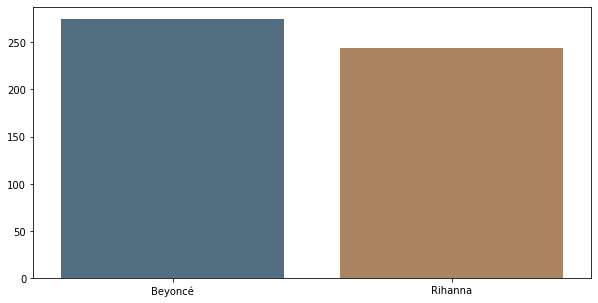

In [57]:
y = list(data['artista'].value_counts())
x = list(np.unique(data['artista']))

plt.figure(figsize=(10, 5))
sns.barplot(x, y, saturation=0.3)

Temos uma informação super importante, trata-se de uma classificação binaria, pois há somente duas classes.

Além disso, os dados não estão tão desbalanceados, podemos checar a entropia para ter certeza. Lembrando que, pela entropia de Shannon:

0 - Completamente desbalanceado;

1 - Completamente Balanceado

In [55]:
print("Entropia:", entropy([new_val/sum(y) for new_val in y], base=2))

Entropia: 0.9975791349905527
